# Complete Statistical Analysis

## Preliminaries

### Imports

In [9]:
import numpy as np
import os

import ruptures as rpt

import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, kstest, jarque_bera
from statsmodels.multivariate.manova import MANOVA
from scipy.spatial.distance import mahalanobis
import warnings
warnings.filterwarnings("ignore")

# ....

In [10]:
CPA = True
VISUALIZE_CPA = True

#### Raw data directories

In [11]:
using_full = True
if using_full:
  physio_dir = 'CASE_full/data/interpolated/physiological'
  annotations_dir = 'CASE_full/data/interpolated/annotations'
  metadata_dir = 'CASE_full/metadata'
  total_num_participants = 30
else:
  physio_dir = 'CASE_snippet/data/interpolated/physiological'
  annotations_dir = 'CASE_snippet/data/interpolated/annotations'
  metadata_dir = 'CASE_snippet/metadata'
  total_num_participants = 2

# Participants to include
sub_nums = range(1, total_num_participants+1)

### Utility Functions

In [12]:
def load_csv_data(file_path):
    """
    Loads csv data
    """
    data = pd.read_csv(file_path)
    return data
    
    
def find_data_folder(folder_path, start_path='/content/drive'):
  '''
    :file_path: The complete path of the folder that includes the files.
    :start_path: The root folder on Drive from which we start the search
  '''
  #Search the root folder of the data and if found, continue searching the full path.
  start_data_folder = folder_path.split('/')[0]
  for root, dirs, files in os.walk(start_path):
      if start_data_folder in dirs:
          return os.path.join(root, folder_path)
  raise Exception(f"{start_data_folder} folder not found. Please check the directory structure.")


def plot_signal_segment(raw_signal, cleaned_signal, title, start_time, duration, sampling_rate=1000):
    """ Utility. Makes two graphs of a raw and a cleaned signal for demonstration """
   
    start_sample = int(start_time * sampling_rate)
    end_sample = int((start_time + duration) * sampling_rate)
 
    plt.figure(figsize=(14, 6))
    # Plot raw signal
    plt.subplot(2, 1, 1)
    plt.plot(raw_signal[start_sample:end_sample], label='Raw Signal')
    plt.title(f'Raw {title} Segment ({start_time}-{start_time + duration} sec)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Plot clean signal
    plt.subplot(2, 1, 2)
    plt.plot(cleaned_signal[start_sample:end_sample], label='Cleaned Signal')
    plt.title(f'Cleaned {title} Segment ({start_time}-{start_time + duration} sec)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()


def read_store_files(files_path, file_type='.csv'):
  '''
    :files_path: The complete Drive path that includes the files
    :file_type: The type of file we are searching for
  '''

  data_list = []
  files_names = []
  for file in os.listdir(files_path):
    if file.endswith(file_type):
      file_path = os.path.join(files_path, file)
      if file_type == '.csv':
        data = pd.read_csv(file_path)
      elif file_type == '.xlsx':
        data = pd.read_excel(file_path)

      data_list.append(data)
      files_names.append(file)

  return data_list, files_names


def retrieve_metadata(metadata_dir):
    # Retrieve metadata by reading the .xlsx files in the metadata_dir
    metadata, metadata_names = read_store_files(metadata_dir,'.xlsx')
    print(f'Metadata files: {metadata_names}')

    # Strip column names from whitespace 
    for i in range(len(metadata)):
        metadata[i].columns = metadata[i].columns.str.strip()

    # Store each metadata file separately (based on name)
    for i, file in enumerate(metadata_names):
        if file == 'videos.xlsx':
            videos_data = metadata[i].drop(metadata[i].columns[2:], axis=1).drop([0]).rename(columns={'Video-label': 'label', 'Video-ID': 'video_id'}).dropna()
            videos_data['video_id'] = videos_data['video_id'].astype(int)
        elif file == 'participants.xlsx':
            participant_data = metadata[i].rename(columns={'Participant-ID': 'participant_id', 'Age-Group': 'age_group', 'Video Sequence Used': 'sequence'})
        elif file == 'videos_duration_num.xlsx':
            duration_data = metadata[i].rename(columns={'video-ID': 'video_id', 'video-duration (in ms)': 'duration'})
        elif file == 'seqs_order_num.xlsx':
            sequence_order_data = metadata[i]
    
    return videos_data, participant_data, duration_data, sequence_order_data
# ....

### Dependent Variables (Features Extraction)

#### Change Point Analysis

In [13]:
def apply_cpa(num_participants, annotations_dir, physio_dir, annotation_videos_dir, 
              physio_videos_dir, annotations_after_cpa_dir, physio_after_cpa_dir):
    
    def keep_scary_videos(num_participants, data_dir, output_dir):
        ''' 
        Keeps scary videos with a reset index
        :num_participants: The number of participants
        :current_dir: The directory that contains the annotation data from all the participants
        '''
        
        print(f'Participant:', end=' ')
        for participant in range(num_participants):
            print(participant+1, end=', ')
            # Read the participant's file
            data = pd.read_csv(f'{data_dir}/sub_{participant+1}.csv')

            # Keep only the segments of scary-1 and scary-2
            scary_1_segment = data[data['video'] == 7].reset_index(drop=True)
            scary_2_segment = data[data['video'] == 8].reset_index(drop=True)
            
            if 'annotation' in data_dir:
                # Rename the index column to 'timepoint' and make it start from 0, increasing by 50
                scary_1_segment.index = scary_1_segment.index * 50
                scary_1_segment.index.name = 'timepoint'
                
                scary_2_segment.index = scary_2_segment.index * 50
                scary_2_segment.index.name = 'timepoint'
            else:
                # Rename the index column to 'timepoint' 
                scary_1_segment.index.name = 'timepoint'
                scary_2_segment.index.name = 'timepoint'
            
            # Save the extracted segments in CSV files
            scary_1_segment.to_csv(f'{output_dir}/sub_{participant+1}_scary_1.csv')
            scary_2_segment.to_csv(f'{output_dir}/sub_{participant+1}_scary_2.csv')
        print()


    def combine_valence_arousal(valence, arousal, neutral_value=5):
        """ Adds the distance of valence and arousal from 5 (neutral_value) """
        combined_intensity = (valence - neutral_value).abs() + (arousal - neutral_value).abs()
        return combined_intensity


    def detect_change_points(df, model="rbf", pen=20):
        algo = rpt.Pelt(model=model).fit(df.values)
        change_points = algo.predict(pen=pen)
        return change_points


    def get_segments_excluding_first_last(change_points, series_length):
        """ Removes the first and last segment """
        if len(change_points) > 2:
            return change_points[1], change_points[-2]
        else:
            return 0, series_length

    #------------------------------------------------------------------------------------------------------

    print('1. Keep the scary videos from the Annotation and Physiological sequences\n')
    print(f'- Annotation Sequences')
    # Keep the two scary videos from each annotation sequence and store them in the "annotation_videos_dir"
    keep_scary_videos(num_participants, annotations_dir, annotation_videos_dir)

    print(f'- Physiological Sequences')
    # Keep the two scary videos from each physiological sequence and store them in the "physio_videos_dir"
    keep_scary_videos(num_participants, physio_dir, physio_videos_dir)

    print('\n','-'*50, '\n')
    
    #------------------------------------------------------------------------------------------------------

    print('2. Compute the average start and end change point (CP) for all annotation videos\n')
    # List of files in the annotation_videos and physio_videosdirectories
    annotation_files = os.listdir(annotation_videos_dir)
    physio_files = os.listdir(physio_videos_dir)

    # Separate files for each video
    files_scary_1 = [file for file in annotation_files if "scary_1" in file]
    files_scary_2 = [file for file in annotation_files if "scary_2" in file]

    def perform_cpa_on_annotations(files):
        """ Processes files and get average start and end points for each scary video """
        all_start_points = []
        all_end_points = []

        print('File', end=': ')
        for i, file in enumerate(files):
            print(f"{i+1}", end=', ')
            file_path = os.path.join(annotation_videos_dir, file)
            data = load_csv_data(file_path)
            
            # Keep the valence column and the arousal column separately and call the function that combines their intensity
            valence = data['valence']
            arousal = data['arousal']

            combined_intensity = combine_valence_arousal(valence, arousal)
            
            # Start with a standard pen value of 20
            pen = 15
            # Acceptable change points threshold
            change_points_threshold = 8
            
            while True:
                change_points = detect_change_points(combined_intensity.to_frame(), pen=pen)
                # Increase the pen value (by 5) until the segments are <= change_points_threshold
                if len(change_points) <= change_points_threshold:
                    break
                pen += 5
            
            # After the series is segmented using CPA, remove the first and the last segment
            start, end = get_segments_excluding_first_last(change_points, len(combined_intensity))
            
            # Keep a list of all the start and end points so later the mean can be computed
            all_start_points.append(start)
            all_end_points.append(end)

        # Keep the mean (average) of all start and end points as generar timestamps for our final segmentation
        if all_start_points and all_end_points:
            avg_start_point = int(np.mean(all_start_points))
            avg_end_point = int(np.mean(all_end_points))
        else:
            avg_start_point, avg_end_point = 0, len(combined_intensity)  # Default to entire series if no points

        return avg_start_point, avg_end_point


    # Process files and get average start and end points for each video. One time for scary-1 and one time for scary-2
    print(f'- CPA on Scary 1')
    avg_start_scary_1, avg_end_scary_1 = perform_cpa_on_annotations(files_scary_1)
    print(f'\n- CPA on Scary 2')
    avg_start_scary_2, avg_end_scary_2 = perform_cpa_on_annotations(files_scary_2)

    print()
    print(f"\nAverage start and end points for scary_1: {avg_start_scary_1}, {avg_end_scary_1}")
    print(f"Average start and end points for scary_2: {avg_start_scary_2}, {avg_end_scary_2}")
    print('\n','-'*50, '\n')

    #------------------------------------------------------------------------------------------------------

    print("3. Apply the average start and end points to each participant's Annotation and Physiological data\n")
    
    print('- Annotation data')
    # Apply the average start and end points to each participant's data and save the new CSVs in the "annotations_after_cpa_dir"
    print('File', end=': ')
    for i, file in enumerate(annotation_files):
        print(f"{i+1}", end=', ')
        file_path = os.path.join(annotation_videos_dir, file)
        data = load_csv_data(file_path)
        
        if "scary_1" in file:
            start, end = avg_start_scary_1, avg_end_scary_1
        else:
            start, end = avg_start_scary_2, avg_end_scary_2
        
        most_significant_segment = data.iloc[start:end]
        
        # Save to CSV
        output_file_path = os.path.join(annotations_after_cpa_dir, f"{os.path.splitext(file)[0]}_cpa.csv")
        most_significant_segment.to_csv(output_file_path, index=False)
    
    #------------------------------------------------------------------------------------------------------

    print('\n- Physiological data')
    # Apply the average start and end points to each participant's data and save the new CSVs in the "physio_after_cpa_dir"
    print('File', end=': ')
    for i, file in enumerate(physio_files):
        print(f"{i+1}", end=', ')
        file_path = os.path.join(physio_videos_dir, file)
        data = load_csv_data(file_path)
        
        if "scary_1" in file:
            start, end = avg_start_scary_1*50, avg_end_scary_1*50
        else:
            start, end = avg_start_scary_2*50, avg_end_scary_2*50
        
        most_significant_segment = data.iloc[start:end]
        
        # Save to CSV
        output_file_path = os.path.join(physio_after_cpa_dir, f"{os.path.splitext(file)[0]}_cpa.csv")
        most_significant_segment.to_csv(output_file_path, index=False)
        

    # Save average starting and ending times in a csv for later use
    # These tme points are based on the segmented scary video and not the whole series
    # For example if avg_start_scary_1 = 300, it means that the "important" part of the video data starts 300ms after the beginning of the video.
    start_end_times = {
        'Annotation Start scary_1': avg_start_scary_1, 
        'Annotation End scary_1': avg_end_scary_1, 
        'Annotation Start scary_2': avg_start_scary_2, 
        'Annotation End scary_2': avg_end_scary_2,
        'Physio Start scary_1': avg_start_scary_1*50, 
        'Physio End scary_1': avg_end_scary_1*50, 
        'Physio Start scary_2': avg_start_scary_2*50, 
        'Physio End scary_2': avg_end_scary_2*50
    }

    # Save to CSV
    pd.DataFrame([start_end_times]).to_csv('CPA_Start_End_times.csv', index=False)
    print('\n','-'*50, '\n')
    

In [14]:
def visualize_cpa_results(annotation_videos_dir, physio_videos_dir):
    print('5. Visualize the CPA segments\n')
    # NOTE: Change participant number to inpsect
    participant_id = 11

    # Example: Plot the annotation segments extracted from CPA
    example_file_scary_1_annotation = pd.read_csv(f'{annotation_videos_dir}/sub_{participant_id}_scary_1.csv')
    example_file_scary_2_annotation = pd.read_csv(f'{annotation_videos_dir}/sub_{participant_id}_scary_2.csv')

    # Segments for video 1 and 2
    segments = pd.read_csv('CPA_Start_End_times.csv')
    segments_scary_1_annotation = [segments['Annotation Start scary_1'].values[0], segments['Annotation End scary_1'].values[0]]
    segments_scary_2_annotation = [segments['Annotation Start scary_2'].values[0], segments['Annotation End scary_2'].values[0]]

    print("1. Annotation Scary-1: Valence")
    print("2. Annotation Scary-1: Arousal")
    print("3. Annotation Scary-2: Valence")
    print("4. Annotation Scary-2: Arousal")

    rpt.display(example_file_scary_1_annotation['valence'], segments_scary_1_annotation)
    rpt.display(example_file_scary_1_annotation['arousal'], segments_scary_1_annotation)
    rpt.display(example_file_scary_2_annotation['valence'], segments_scary_2_annotation)
    rpt.display(example_file_scary_2_annotation['arousal'], segments_scary_2_annotation)


    # Example: Plot the physio segments extracted from CPA
    example_file_scary_1_physio = pd.read_csv(f'{physio_videos_dir}/sub_{participant_id}_scary_1.csv')
    example_file_scary_2_physio = pd.read_csv(f'{physio_videos_dir}/sub_{participant_id}_scary_2.csv')

    # Segpents for video 1 and 2
    segments = pd.read_csv('CPA_Start_End_times.csv')
    segments_scary_1_physio = [segments['Physio Start scary_1'].values[0], segments['Physio End scary_1'].values[0]]
    segments_scary_2_physio = [segments['Physio Start scary_2'].values[0], segments['Physio End scary_2'].values[0]]

    print("\n5. Physio Scary-1: ECG")
    print("6. Physio Scary-1: GSR")
    print("7. Physio Scary-2: ECG")
    print("8. Physio Scary-2: GSR")

    rpt.display(example_file_scary_1_physio['ecg'], segments_scary_1_physio)
    rpt.display(example_file_scary_1_physio['gsr'], segments_scary_1_physio)
    rpt.display(example_file_scary_2_physio['ecg'], segments_scary_2_physio)
    rpt.display(example_file_scary_2_physio['gsr'], segments_scary_2_physio)

1. Keep the scary videos from the Annotation and Physiological sequences

- Annotation Sequences
Participant: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
- Physiological Sequences
Participant: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 

 -------------------------------------------------- 

2. Compute the average start and end change point (CP) for all annotation videos

- CPA on Scary 1
File: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
- CPA on Scary 2
File: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 

Average start and end points for scary_1: 1003, 3148
Average start and end points for scary_2: 955, 2363

 -------------------------------------------------- 

3. Apply the average start and end points to each participa

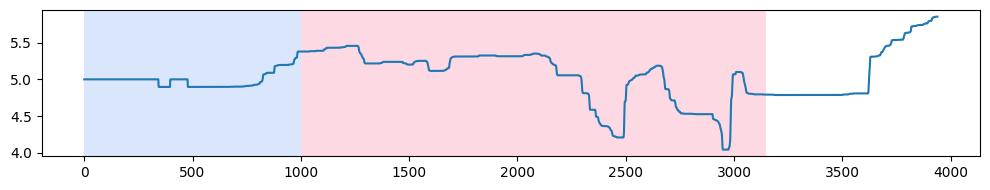

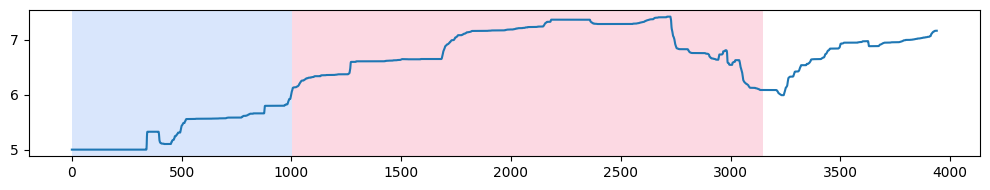

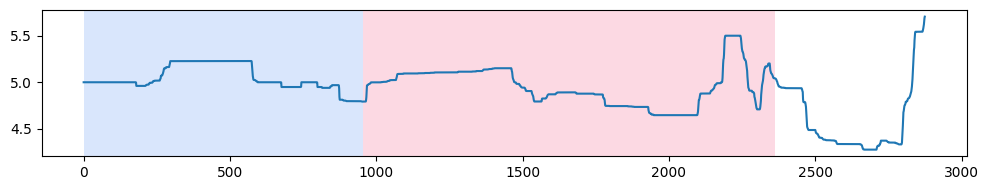

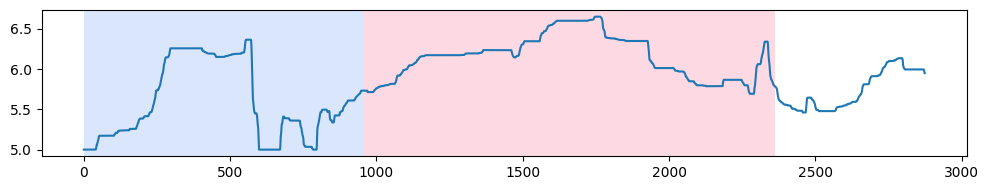

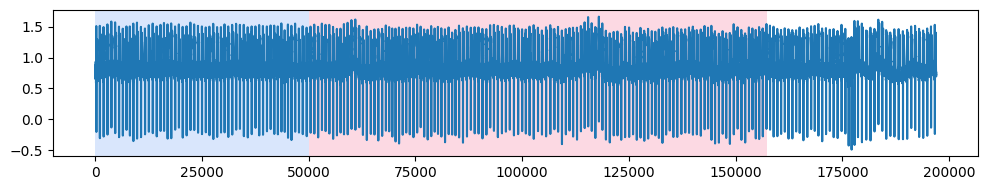

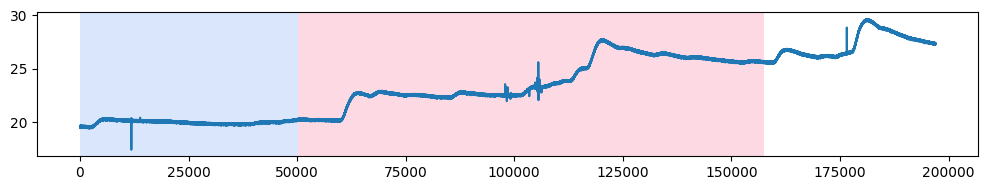

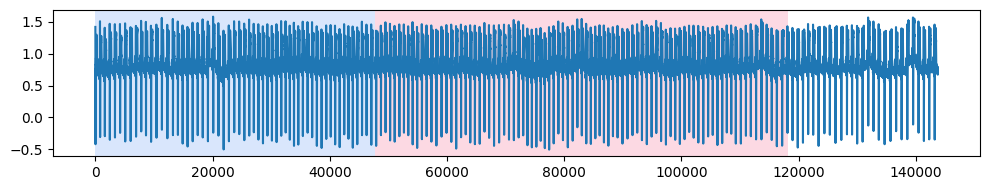

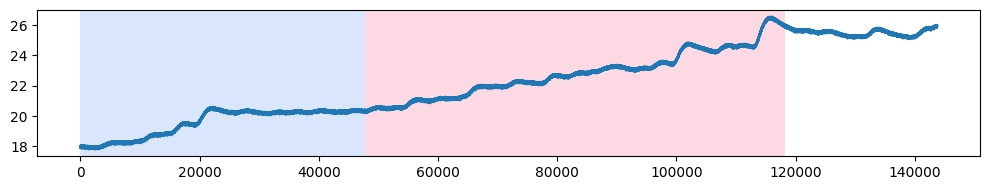

In [15]:
if CPA:
    # Define Directory paths
    annotation_videos_dir = 'annotation_videos'
    annotations_after_cpa_dir = 'annotations_after_cpa'

    physio_videos_dir = 'physio_videos'
    physio_after_cpa_dir = 'physio_after_cpa'

    # Make sure that the directories exist
    os.makedirs(annotation_videos_dir, exist_ok=True)
    os.makedirs(annotations_after_cpa_dir, exist_ok=True)

    os.makedirs(physio_videos_dir, exist_ok=True)
    os.makedirs(physio_after_cpa_dir, exist_ok=True)
    
    apply_cpa(total_num_participants, annotations_dir, physio_dir, annotation_videos_dir, 
              physio_videos_dir, annotations_after_cpa_dir, physio_after_cpa_dir)
    
    
    if VISUALIZE_CPA:
        visualize_cpa_results(annotation_videos_dir, physio_videos_dir)

##### Clean Signal and Extract Features from ECG and GSR data

In [17]:
def preprocess_signal(signal, data_type, visualization=False):
    """ Just cleans the signal (NOTE: ok for now).
    Set visualization to True to see a before-after example
    """
    if data_type == "ecg":
        cleaned_signal = nk.ecg_clean(signal, sampling_rate=1000)
    elif data_type == "gsr":
        cleaned_signal = nk.eda_clean(signal, sampling_rate=1000)
    else:
        raise ValueError("Unsupported data type")

    if visualization:
        # Plot a 5-second segment for demonstration
        plot_signal_segment(signal, cleaned_signal, 'Signal', start_time=20, duration=5 if data_type=='ecg' else 200)
    return cleaned_signal


def swap_scary_videos(df1, df2):
    """ Swaps df scary videos order dependent on their original timestamp """
    if df1['daqtime'].iloc[0] > df2['daqtime'].iloc[0]:
        return True, df2, df1
    return False, df1, df2


def extract_segments(cleaned_signal, start_time, end_time, original_timestamps):
    """ Utility. Extracts the signal segment given timestamps """
    start_index = original_timestamps[original_timestamps >= start_time].index[0]
    end_index = original_timestamps[original_timestamps <= end_time].index[-1]

    segment = cleaned_signal[start_index:end_index+1]
    return segment


def extract_features(segment, data_type, sampling_rate=1000):
    """ Extracts ECG and GSR features.

    ECG:
    - Heart Rate: Mean heart rate over the segment.
    - HRV SDNN: Standard deviation of NN intervals (HRV time-domain).
    - Mean RR Interval: Mean of RR intervals.
    GSR:
    - SCL: Skin conductance level (mean tonic level).
    - SCR: Skin conductance response (mean phasic level).
    - Peak Amplitude: Maximum amplitude of the SCR peaks.

    Parameters:
    - segment: Array-like, the segment of the signal to analyze.
    - data_type: str, type of the signal ("ecg" or "gsr").
    - sampling_rate: int, sampling rate of the signal in Hz.

    Returns:
    - dict: A dictionary containing the extracted features.
    """
    if data_type == "ecg":
        signals, info = nk.ecg_process(segment, sampling_rate=sampling_rate)
        heart_rate = signals['ECG_Rate']

        peaks, info = nk.ecg_peaks(segment, sampling_rate=sampling_rate)
        hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_rate).iloc[0].to_dict()

        features = {
            "Heart Rate": heart_rate.mean(),
            "HRV SDNN": hrv_time['HRV_SDNN'],
            "Mean RR Interval": hrv_time['HRV_MeanNN']
        }
    elif data_type == "gsr":
        signals, info = nk.eda_process(segment, sampling_rate=sampling_rate)
        scl = signals['EDA_Tonic'].mean()
        scr = signals['EDA_Phasic'].mean()

        # peaks, info = nk.eda_peaks(segment, sampling_rate=sampling_rate)
        peak_amplitude = signals['EDA_Phasic'].max()

        features = {
            "SCL": scl,
            "SCR": scr,
            "Peak Amplitude": peak_amplitude
        }
    else:
        raise ValueError("Unsupported data type")
    return features

In [18]:
# Decide on Physio data directory based on whether CPA was applied
physio_dir = physio_after_cpa_dir if CPA else physio_videos_dir

# Initialize list (NOTE: we will convert to dataframe later)
results = []

# Features extraction loops
for sub_num in range(1, total_num_participants+1):
    print(f"\n- Participant {sub_num}")

    if CPA:     
        scary_1_filename = f'sub_{sub_num}_scary_1_cpa.csv'
        scary_2_filename = f'sub_{sub_num}_scary_2_cpa.csv'
    else:
        scary_1_filename = f'sub_{sub_num}_scary_1.csv'
        scary_2_filename = f'sub_{sub_num}_scary_2.csv'

    scary_1 = load_csv_data(os.path.join(physio_dir, scary_1_filename))
    scary_2 = load_csv_data(os.path.join(physio_dir, scary_2_filename))

    # Swap with 
    swapped, scary_1st, scary_2nd = swap_scary_videos(scary_1, scary_2)

    # Get the start and end timestamps
    scary_1st_start, scary_1st_end = scary_1st['daqtime'].iloc[0], scary_1st['daqtime'].iloc[-1]
    scary_2nd_start, scary_2nd_end = scary_2nd['daqtime'].iloc[0], scary_2nd['daqtime'].iloc[-1]
    
    print(f"scary_1st_start: {scary_1st_start}, scary_1st_end: {scary_1st_end}, scary_2nd_start: {scary_2nd_start}, scary_2nd_start: {scary_2nd_start}, scary_2nd_end: {scary_2nd_end}")

    if swapped: print("Scary videos sequence swapped for chronological order")

    # Clean each segment separately
    ecg_cleaned_scary_1st = pd.Series(preprocess_signal(scary_1st['ecg'], data_type="ecg", visualization=False))
    ecg_cleaned_scary_2nd = pd.Series(preprocess_signal(scary_2nd['ecg'], data_type="ecg", visualization=False))
    gsr_cleaned_scary_1st = pd.Series(preprocess_signal(scary_1st['gsr'], data_type="gsr", visualization=False))
    gsr_cleaned_scary_2nd = pd.Series(preprocess_signal(scary_2nd['gsr'], data_type="gsr", visualization=False))

    # Concatenate the cleaned segments
    ecg_cleaned = pd.concat([ecg_cleaned_scary_1st, ecg_cleaned_scary_2nd], ignore_index=True)
    gsr_cleaned = pd.concat([gsr_cleaned_scary_1st, gsr_cleaned_scary_2nd], ignore_index=True)

    original_timestamps = pd.concat([scary_1st['daqtime'], scary_2nd['daqtime']], ignore_index=True)

    # Extract segment data (NOTE: something like this could be used later even if we segment the videos further)
    ecg_scary_1st_segment = extract_segments(ecg_cleaned, scary_1st_start, scary_1st_end, original_timestamps)
    ecg_scary_2nd_segment = extract_segments(ecg_cleaned, scary_2nd_start, scary_2nd_end, original_timestamps)

    gsr_scary_1st_segment = extract_segments(gsr_cleaned, scary_1st_start, scary_1st_end, original_timestamps)
    gsr_scary_2nd_segment = extract_segments(gsr_cleaned, scary_2nd_start, scary_2nd_end, original_timestamps)

    # Calculate ECG and GSR features for both videos
    ecg_features_scary_1st = extract_features(ecg_scary_1st_segment, data_type="ecg")
    ecg_features_scary_2nd = extract_features(ecg_scary_2nd_segment, data_type="ecg")

    gsr_features_scary_1st = extract_features(gsr_scary_1st_segment, data_type="gsr")
    gsr_features_scary_2nd = extract_features(gsr_scary_2nd_segment, data_type="gsr")

    # Calculate differences for all features (to use in statistical analysis)
    ecg_features_diff = {f'diff_ecg_{key}': ecg_features_scary_2nd[key] - ecg_features_scary_1st[key] for key in ecg_features_scary_1st.keys()}
    gsr_features_diff = {f'diff_gsr_{key}': gsr_features_scary_2nd[key] - gsr_features_scary_1st[key] for key in gsr_features_scary_1st.keys()}

    # Compile all features into a single dictionary
    participant_features = {'participant': sub_num}
    participant_features.update({f'scary_1st_ecg_{key}': value for key, value in ecg_features_scary_1st.items()})
    participant_features.update({f'scary_2nd_ecg_{key}': value for key, value in ecg_features_scary_2nd.items()})
    participant_features.update(ecg_features_diff)
    participant_features.update({f'scary_1st_gsr_{key}': value for key, value in gsr_features_scary_1st.items()})
    participant_features.update({f'scary_2nd_gsr_{key}': value for key, value in gsr_features_scary_2nd.items()})
    participant_features.update(gsr_features_diff)

    # Add to results
    results.append(participant_features)


# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save
output_filepath = 'preprocessed_data/dv_data.csv'
results_df.to_csv(output_filepath, index=False)

print(f"Results saved to {output_filepath}.")


- Participant 1
scary_1_start: 1081026, scary_1_end: 1188275, scary_2_start: 2235584, scary_2_end: 2305983

- Participant 2
scary_1_start: 1109209, scary_1_end: 1179608, scary_2_start: 2184734, scary_2_end: 2291983
Scary videos sequence swapped for chronological order

- Participant 3
scary_1_start: 536776, scary_1_end: 644025, scary_2_start: 1968834, scary_2_end: 2039233

- Participant 4
scary_1_start: 842459, scary_1_end: 912858, scary_2_start: 1879151, scary_2_end: 1986400
Scary videos sequence swapped for chronological order

- Participant 5
scary_1_start: 577234, scary_1_end: 684483, scary_2_start: 1395626, scary_2_end: 1466025

- Participant 6
scary_1_start: 536001, scary_1_end: 606400, scary_2_start: 1375359, scary_2_end: 1482608
Scary videos sequence swapped for chronological order

- Participant 7
scary_1_start: 775443, scary_1_end: 882692, scary_2_start: 1968834, scary_2_end: 2039233

- Participant 8
scary_1_start: 1081026, scary_1_end: 1188275, scary_2_start: 2235584, scary

In [19]:
# Participant 21: ?
# info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])

### Independent Variables (Predictors)

In [27]:
def compute_independent_variables(sequence_order_data, participant_data, 
                                    videos_data, num_participants, results_name='preprocessed_data/iv_data.csv'):
    
    '''
    :sequence_order_data: Dataframe where each column is a participant and the rows are the sequence of videos whatched
    :participant_data: Dataframe that includes information about each participant. We use it to extract the sequence ID
    :videos_data: Includes the label, ID and duration of each video
    :num_participants: The number of participants
    :results_name: Name of the result CSV file that will contain the Independent Variables for each participant.
    '''

    # Extract video IDs based on labels
    def extract_video_ids(label_list, videos_data):
        return videos_data[videos_data['label'].isin(label_list)].drop(columns=('label'))['video_id'].tolist()
    
    def compute_start_end_points(num_participants):        
        # Initialize start end points dict
        start_end_points = {'scary_1st_start': [], 'scary_1st_end': [], 'scary_2nd_start': [], 'scary_2ndend': []}
        
        for sub_num in range(1, num_participants+1):
            # Define file names   
            if CPA:     
                scary_1_filename = f'sub_{sub_num}_scary_1_cpa.csv'
                scary_2_filename = f'sub_{sub_num}_scary_2_cpa.csv'
            else:
                scary_1_filename = f'sub_{sub_num}_scary_1.csv'
                scary_2_filename = f'sub_{sub_num}_scary_2.csv'
            
            # Retrieve data
            scary_1 = load_csv_data(os.path.join(physio_dir, scary_1_filename))
            scary_2 = load_csv_data(os.path.join(physio_dir, scary_2_filename))
            
            # Swap with 
            _, scary_1st, scary_2nd = swap_scary_videos(scary_1, scary_2)
        
            # Get the start and end timestamps
            scary_1st_start, scary_1st_end = scary_1st['daqtime'].iloc[0], scary_1st['daqtime'].iloc[-1]
            scary_2nd_start, scary_2nd_end = scary_2nd['daqtime'].iloc[0], scary_2nd['daqtime'].iloc[-1]
                        
            start_end_points['scary_1st_start'].append(scary_1st_start)
            start_end_points['scary_1st_end'].append(scary_1st_end)
            start_end_points['scary_2nd_start'].append(scary_2nd_start)
            start_end_points['scary_2nd_end'].append(scary_2nd_end)
        
        pd.DataFrame(start_end_points).to_csv('start_end_points.csv', index=False)
        
    
    SCARY_LABELS=['scary-1', 'scary-2']
    LOW_AROUSAL_LABELS=['relaxed-1', 'relaxed-2', 'boring-1', 'boring-2']

    scary_videos_ids = extract_video_ids(SCARY_LABELS, videos_data) # IDs of the scary videos
    low_arousal_videos_ids = extract_video_ids(LOW_AROUSAL_LABELS, videos_data) # IDs of the low arousal videos
    print(f'Scary videos IDs: {scary_videos_ids}\nLow Arousal videos IDs: {low_arousal_videos_ids}')
    
    # Create and read the scary videos starting and ending points from the csv file
    compute_start_end_points(num_participants)
    start_end_points_df = pd.read_csv('start_end_points.csv')
    
    # Initialize data arrays
    def initialize_arrays(shape, fill_value=0):
        return np.zeros(shape) + fill_value
    
    interlude_durations = initialize_arrays(num_participants) # Interlude time between scary videos for each participant
    count_interlude_videos_total = initialize_arrays(num_participants)  # Initialize count of interlude videos total
    count_interlude_low_arousal = initialize_arrays(num_participants) # Initialize count of interlude low arousal
    logratio_low_div_total = initialize_arrays(num_participants)  # Initialize log ratio (low arousal / total interlude)
    
    # Extract the sequence ID of each participant. It is the same as the participant number but we extract it this way in case the .xlsx change.
    sequence_id_of_participants = np.array([participant_data.iloc[participant]['sequence'] for participant in range(num_participants)])

    # Helper function to compute log ratio
    def compute_log_ratio(count_low, count_total):
        return np.around(np.log((count_low + 1) / (count_total + 1)), decimals=4)
    
    # Process each participant
    for participant in range(num_participants):
        print(f'Participant {participant + 1}')
        
        # Using the sequence id, get the video sequence of the specific participant 
        participant_sequence = pd.DataFrame(sequence_order_data[f'sub_{sequence_id_of_participants[participant]}']).rename(columns={f'sub_{participant+1}': 'sequence'})
        print(f'- Sequence ID: {sequence_id_of_participants[participant]}')
        print(f'- Sequence: {participant_sequence["sequence"].tolist()}')
        
        # Retrieve scary video start and end 
        scary_1st_start, scary_1st_end, scary_2nd_start, scary_2nd_end = \
        start_end_points_df['scary_1st_start'].iloc[participant], start_end_points_df['scary_1st_end'].iloc[participant], \
        start_end_points_df['scary_2nd_start'].iloc[participant], start_end_points_df['scary_2nd_end'].iloc[participant]
        print(f'- Timepoints: Scary 1st start: {scary_1st_start} || Scary 1st end: {scary_1st_end} || Scary 2nd start: {scary_2nd_start} || Scary 2nd end: {scary_2nd_end}')

        # Find locations of the two scary videos in the sequence
        scary_indices = participant_sequence[participant_sequence['sequence'].isin(scary_videos_ids)].index.values.tolist()
        first_scary_loc, second_scary_loc = scary_indices[0], scary_indices[1]
        print(f'- Locs in sequence: Scary 1st: {first_scary_loc} || Scary 2nd: {second_scary_loc}')
        
        # Retrieve all the Interlude videos based on the sequence and the 1st & 2nd scary locations. (if any)
        interlude_videos = participant_sequence.iloc[first_scary_loc + 1 : second_scary_loc][f'sequence'].values.tolist() if second_scary_loc > first_scary_loc + 1 else []
        count_interlude_videos_total[participant] = np.floor(len(interlude_videos) / 2) # Divide by 2 so we don't count the bluVid between each video
        print(f'- Number of interlude videos (no bluVid): {int(count_interlude_videos_total[participant])}')
        
        # Compute Low Arousal Interlude videos
        count_interlude_low_arousal[participant] = len([vid for vid in interlude_videos if vid in low_arousal_videos_ids])
        print(f'- Low Arousal Interlude videos: {int(count_interlude_low_arousal[participant])}')
        
        # Compute the Log Ratio between the total Interlude videos and the Low Arousal Interlude videos  
        logratio_low_div_total[participant] = compute_log_ratio(count_interlude_low_arousal[participant], count_interlude_videos_total[participant])
        print(f'- Log Ratio: {logratio_low_div_total[participant]}')
        
        # Compute Interlude Durations
        interlude_durations[participant] = scary_2nd_start - scary_1st_end
        print(f'- Interlude duration (with bluVid): {interlude_durations[participant]}')
        
    # Save the extracted features in dictionary and save it as dataframe CSV
    data = {
        'Participant': range(1, num_participants + 1),
        'Interlude Duration': interlude_durations[:],
        'Interlude Video Count': count_interlude_videos_total[:],
        'Interlude Low Arousal': count_interlude_low_arousal[:],
        'LogRatio': logratio_low_div_total[:],
    }
    results_df = pd.DataFrame(data)

    results_df.to_csv(results_name, index=False)

In [29]:
# Retrieve the metadata
videos_data, participant_data, duration_data, sequence_order_data = retrieve_metadata(metadata_dir)

# Call the Independent Variable process that extracts the IVs from each participant
compute_independent_variables(sequence_order_data, participant_data, videos_data, total_num_participants)


Scary videos IDs: [7, 8]
Low Arousal videos IDs: [3, 4, 5, 6]
Participant 1
- Sequence ID: 1
- Sequence: [10, 11, 3, 11, 1, 11, 5, 11, 7, 11, 4, 11, 2, 11, 6, 11, 8, 12]
- Timepoints: Scary 1 start: 1081026 || Scary 1 end: 1188275 || Scary 2 start: 2235584 || Scary 2 end: 2305983
- Locs in sequence: Scary 1: 8 || Scary 2: 16
- Number of interlude videos (no bluVid): 3
- Low Arousal Interlude videos: 2
- Log Ratio: -0.2877
- Interlude duration (with bluVid): 1047309.0
Participant 2
- Sequence ID: 2
- Sequence: [10, 11, 2, 11, 6, 11, 4, 11, 8, 11, 1, 11, 3, 11, 5, 11, 7, 12]
- Timepoints: Scary 1 start: 1109209 || Scary 1 end: 1179608 || Scary 2 start: 2184734 || Scary 2 end: 2291983
- Locs in sequence: Scary 1: 8 || Scary 2: 16
- Number of interlude videos (no bluVid): 3
- Low Arousal Interlude videos: 2
- Log Ratio: -0.2877
- Interlude duration (with bluVid): 1005126.0
Participant 3
- Sequence ID: 3
- Sequence: [10, 11, 5, 11, 7, 11, 1, 11, 3, 11, 2, 11, 4, 11, 8, 11, 6, 12]
- Timepoin

## Statistical Analysis

### Data preparation

In [30]:
# Merge the IV and the DV CSV files 
iv_df = pd.read_csv('preprocessed_data/iv_data.csv')
dv_df = pd.read_csv('preprocessed_data/dv_data.csv')

combined_df = pd.concat([dv_df.iloc[:, :1], iv_df.iloc[:, 1:], dv_df.iloc[:, 1:]], axis=1) # Keep the column "Participant" of the dv dataframe and add the iv columns after it.
combined_df.head()

,participant,Interlude Duration,Interlude Video Count,Interlude Low Arousal,LogRatio,scary_1_ecg_Heart Rate,scary_1_ecg_HRV SDNN,scary_1_ecg_Mean RR Interval,scary_2_ecg_Heart Rate,scary_2_ecg_HRV SDNN,...,diff_ecg_Mean RR Interval,scary_1_gsr_SCL,scary_1_gsr_SCR,scary_1_gsr_Peak Amplitude,scary_2_gsr_SCL,scary_2_gsr_SCR,scary_2_gsr_Peak Amplitude,diff_gsr_SCL,diff_gsr_SCR,diff_gsr_Peak Amplitude
0,1,1047309.0,3.0,2.0,-0.2877,92.483439,77.594044,648.670732,78.516715,51.807616,...,115.790807,11.776910,-0.000703,0.510677,5.809353,0.000081,0.062782,-5.967558,0.000784,-0.447895
1,2,1005126.0,3.0,2.0,-0.2877,67.131485,53.681856,893.909091,67.130786,79.815992,...,0.334607,30.488877,0.000077,1.632915,36.597131,0.001055,1.198868,6.108254,0.000978,-0.434047
2,3,1324809.0,4.0,2.0,-0.5108,77.779168,81.810765,765.833333,89.556915,41.281199,...,-95.641026,29.066225,-0.001578,0.658489,31.374457,0.004343,0.533487,2.308232,0.005921,-0.125002
3,4,966293.0,3.0,3.0,0.0000,54.624825,129.505844,1083.171875,57.818861,94.778325,...,-44.468905,16.290612,0.000063,0.882682,30.208996,-0.011311,2.665119,13.918384,-0.011374,1.782437
4,5,711143.0,2.0,2.0,0.0000,72.280890,103.350964,830.664062,77.437405,45.402658,...,-56.608507,41.150203,-0.028079,4.827195,37.086220,0.013443,2.564614,-4.063984,0.041522,-2.262581


In [32]:
# Transform Interlude Duration to seconds
combined_df["InterludeDuration"] = combined_df["InterludeDuration"] / 1000

# Round all values to 4 decimals
combined_df = combined_df.round(4)
combined_df.head()

# Save the combined DataFrame
output_path = 'preprocessed_data/iv_dv_data.csv'  
combined_df.to_csv(output_path, index=False)

print(f'iv_dv_clean CSV saved to {output_path}')

KeyError: 'InterludeDuration'

### Correlation

In [ ]:
# Load dataset
data_path = "preprocessed_data/iv_dv_data.csv"
data = load_csv_data(data_path)
data.head()

,participant,InterludeDuration,Interlude Video Count,Interlude Low Arousal,LowArousalRatioLog,scary_1_ecg_Heart Rate,scary_1_ecg_HRV SDNN,scary_1_ecg_Mean RR Interval,scary_2_ecg_Heart Rate,scary_2_ecg_HRV SDNN,...,diff_ecg_Mean RR Interval,scary_1_gsr_SCL,scary_1_gsr_SCR,scary_1_gsr_Peak Amplitude,scary_2_gsr_SCL,scary_2_gsr_SCR,scary_2_gsr_Peak Amplitude,diff_gsr_SCL,diff_gsr_SCR,diff_gsr_Peak Amplitude
0,1,959.959,3.0,2.0,-0.2877,92.4834,77.5940,648.6707,78.5167,51.8076,...,115.7908,11.7769,-0.0007,0.5107,5.8094,0.0001,0.0628,-5.9676,0.0008,-0.4479
1,2,929.376,3.0,2.0,-0.2877,67.1315,53.6819,893.9091,67.1308,79.8160,...,0.3346,30.4889,0.0001,1.6329,36.5971,0.0011,1.1989,6.1083,0.0010,-0.4340
2,3,1237.459,4.0,2.0,-0.5108,77.7792,81.8108,765.8333,89.5569,41.2812,...,-95.6410,29.0662,-0.0016,0.6585,31.3745,0.0043,0.5335,2.3082,0.0059,-0.1250
3,4,890.543,3.0,3.0,0.0000,54.6248,129.5058,1083.1719,57.8189,94.7783,...,-44.4689,16.2906,0.0001,0.8827,30.2090,-0.0113,2.6651,13.9184,-0.0114,1.7824
4,5,623.793,2.0,2.0,0.0000,72.2809,103.3510,830.6641,77.4374,45.4027,...,-56.6085,41.1502,-0.0281,4.8272,37.0862,0.0134,2.5646,-4.0640,0.0415,-2.2626


In [ ]:
# Keep only relevant columns (differences)
#relevant_columns = ['InterludeDuration', 'LowArousalRatioLog', 'diff_ecg_Mean RR Interval', 'diff_ecg_Heart Rate', 'diff_ecg_HRV SDNN', 'diff_gsr_Peak Amplitude', 'diff_gsr_SCR', 'diff_gsr_SCL']
relevant_columns = ['InterludeDuration', 'LowArousalRatioLog', 'diff_ecg_Mean RR Interval', 'diff_ecg_Heart Rate', 'diff_gsr_Peak Amplitude', 'diff_gsr_SCL']
data = data[relevant_columns]
data.head()

,InterludeDuration,LowArousalRatioLog,diff_ecg_Mean RR Interval,diff_ecg_Heart Rate,diff_gsr_Peak Amplitude,diff_gsr_SCL
0,959.959,-0.2877,115.7908,-13.9667,-0.4479,-5.9676
1,929.376,-0.2877,0.3346,-0.0007,-0.4340,6.1083
2,1237.459,-0.5108,-95.6410,11.7777,-0.1250,2.3082
3,890.543,0.0000,-44.4689,3.1940,1.7824,13.9184
4,623.793,0.0000,-56.6085,5.1565,-2.2626,-4.0640


In [ ]:
# Calculate the Pearson correlation matrix
correlation_matrix = data.corr(method='pearson')
correlation_matrix

,InterludeDuration,LowArousalRatioLog,diff_ecg_Mean RR Interval,diff_ecg_Heart Rate,diff_gsr_Peak Amplitude,diff_gsr_SCL
InterludeDuration,1.000000,-0.331677,0.124634,-0.088964,0.350589,-0.068657
LowArousalRatioLog,-0.331677,1.000000,-0.130415,0.030252,0.032381,0.183604
diff_ecg_Mean RR Interval,0.124634,-0.130415,1.000000,-0.968807,-0.157079,-0.625681
diff_ecg_Heart Rate,-0.088964,0.030252,-0.968807,1.000000,0.151738,0.582998
diff_gsr_Peak Amplitude,0.350589,0.032381,-0.157079,0.151738,1.000000,0.619637
diff_gsr_SCL,-0.068657,0.183604,-0.625681,0.582998,0.619637,1.000000


### Regression Analyses

### NOTE: ASK LUKAS 
### 1)problem if the interaction term is 0?
### 2)when checking assumptions with or without interaction

### Linear Multiple Regression

##### Assumptions Checking

###### Set up

In [ ]:
# Define predictors and response variables
X = data[['InterludeDuration', 'LowArousalRatioLog']]
y_vars = ['diff_ecg_Mean RR Interval', 'diff_ecg_Heart Rate', 'diff_gsr_Peak Amplitude', 'diff_gsr_SCL']

# Define model with interaction term
X_w_interaction = X.copy()
X_w_interaction['Interaction'] = X_w_interaction['InterludeDuration'] * X_w_interaction['LowArousalRatioLog']

# Add constant to the predictors
X = sm.add_constant(X)
X_w_interaction = sm.add_constant(X_w_interaction)

# Fit models and store in dictionary
models = {}

for i, response_var in enumerate(y_vars, 1):
    model_name = f'model{i}'
    models[model_name] = {
        'model_no_interaction': sm.OLS(data[response_var], X).fit(),
        'model_w_interaction': sm.OLS(data[response_var], X_w_interaction).fit(),
        'response_var': response_var
    }


def derive_formula(model):
    """ Derive linear formula from model """
    predictors = model.model.exog_names
    response = model.model.endog_names
    formula = f"{response} ~ " + " + ".join(predictors)
    return formula

###### Choose model

In [ ]:
model_name = "model4" # put model here... ('model1', 'model2', 'model3', 'model4')

In [ ]:
model_info = models[model_name]
model = model_info['model_no_interaction']
# print(model.summary())
response_var = model_info['response_var']
print(f"Selected model: {model_name}\n-Predictors: {', '.join(X.columns.tolist())}\n-Response Variable: {response_var}")

Selected model: model4
-Predictors: const, InterludeDuration, LowArousalRatioLog
-Response Variable: diff_gsr_SCL


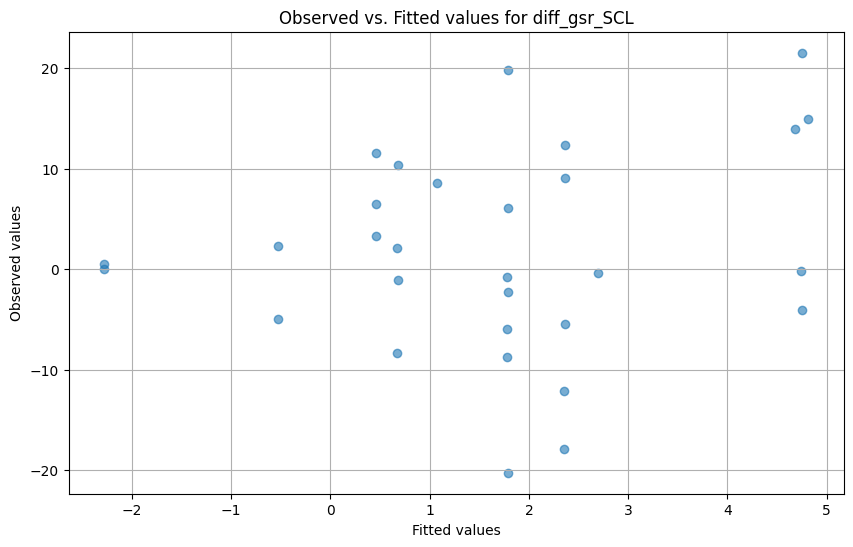

In [ ]:
# 1. Linearity: Plot observed vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, data[response_var], alpha=0.6)
plt.xlabel('Fitted values')
plt.ylabel('Observed values')
plt.title(f'Observed vs. Fitted values for {response_var}')
plt.grid(True)
plt.show()

In [ ]:
# 2. Independence: Durbin-Watson test
dw_test = sm.stats.durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_test}')

Durbin-Watson statistic: 2.8552695974657363


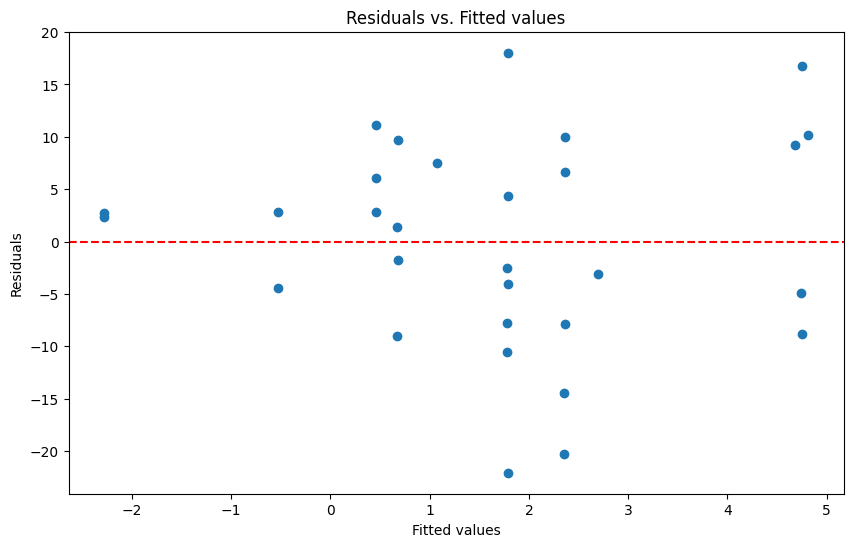

{'LM Statistic': 2.449078500982045, 'LM-Test p-value': 0.2938930802254319, 'F-Statistic': 1.2000527737134343, 'F-Test p-value': 0.3167384646877249}


In [ ]:
# 3. Homoscedasticity: Plot residuals vs. fitted values
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.show()

# Breusch-Pagan test for homoscedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

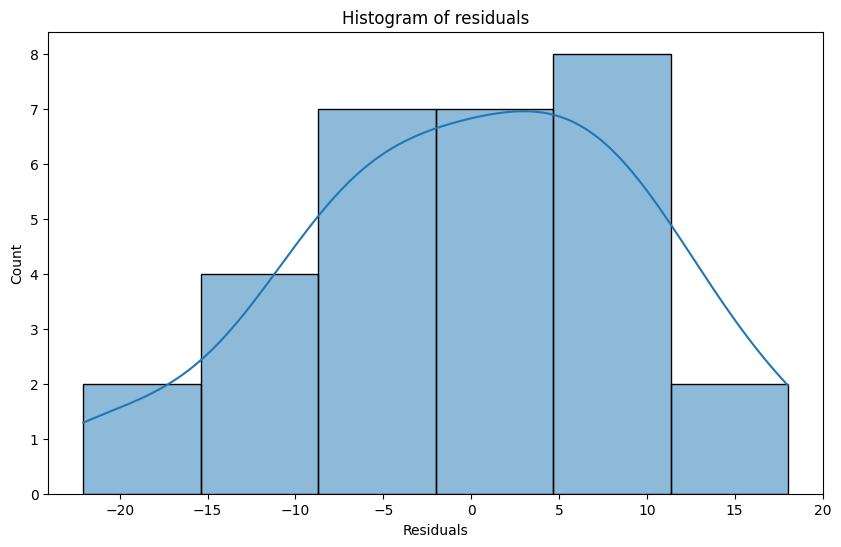

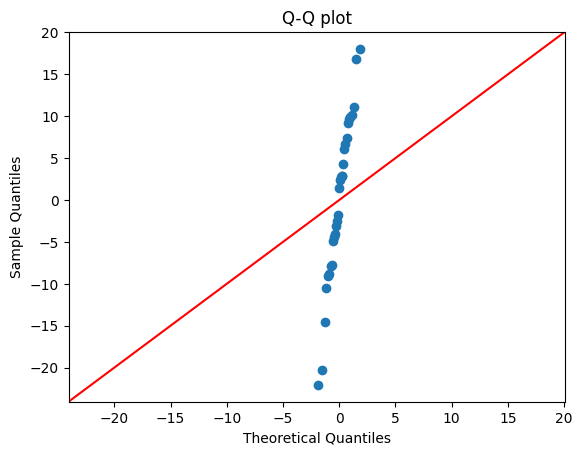

Shapiro-Wilk test: ShapiroResult(statistic=0.976733922958374, pvalue=0.7336770296096802)
Kolmogorov-Smirnov test: KstestResult(statistic=0.490128827377758, pvalue=3.604870974935121e-07, statistic_location=2.331208934808287, statistic_sign=-1)
Jarque-Bera test: SignificanceResult(statistic=0.6959010130768489, pvalue=0.706133824356828)


In [ ]:
# 4. Normality: Histogram and Q-Q plot of residuals
plt.figure(figsize=(10, 6))
sns.histplot(model.resid, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of residuals')
plt.show()

# Q-Q plot
sm.qqplot(model.resid, line='45')
plt.title('Q-Q plot')
plt.show()

# Shapiro-Wilk test
shapiro_test = shapiro(model.resid)
print(f'Shapiro-Wilk test: {shapiro_test}')

# Kolmogorov-Smirnov test
ks_test = kstest(model.resid, 'norm')
print(f'Kolmogorov-Smirnov test: {ks_test}')

# Jarque-Bera test
jb_test = jarque_bera(model.resid)
print(f'Jarque-Bera test: {jb_test}')

In [ ]:
# 5. Multicollinearity: Variance Inflation Factor (VIF)
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


             Variable        VIF
0               const  11.654906
1   InterludeDuration   1.123608
2  LowArousalRatioLog   1.123608


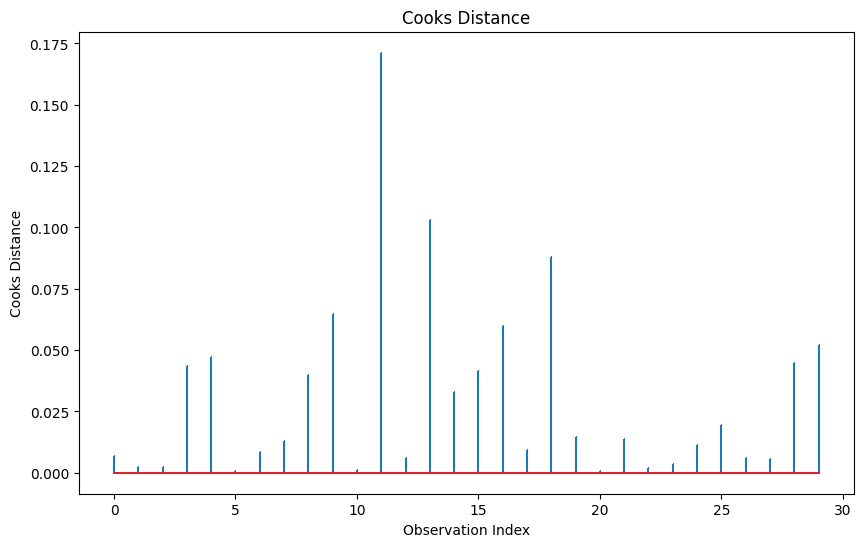

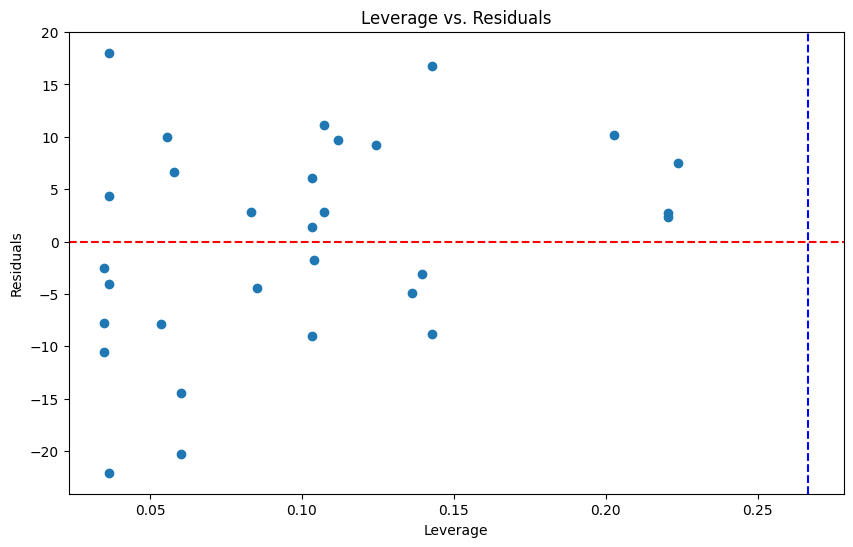

In [ ]:
# Additional Assumptions:

# Influential Points: Cook's Distance
influence = OLSInfluence(model)
cooks_d = influence.cooks_distance[0]

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title('Cooks Distance')
plt.xlabel('Observation Index')
plt.ylabel('Cooks Distance')
plt.show()

# Leverage plot
plt.figure(figsize=(10, 6))
plt.scatter(influence.hat_matrix_diag, model.resid)
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.title('Leverage vs. Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.axvline(2 * (X.shape[1] + 1) / len(X), color='blue', linestyle='--')
plt.show()

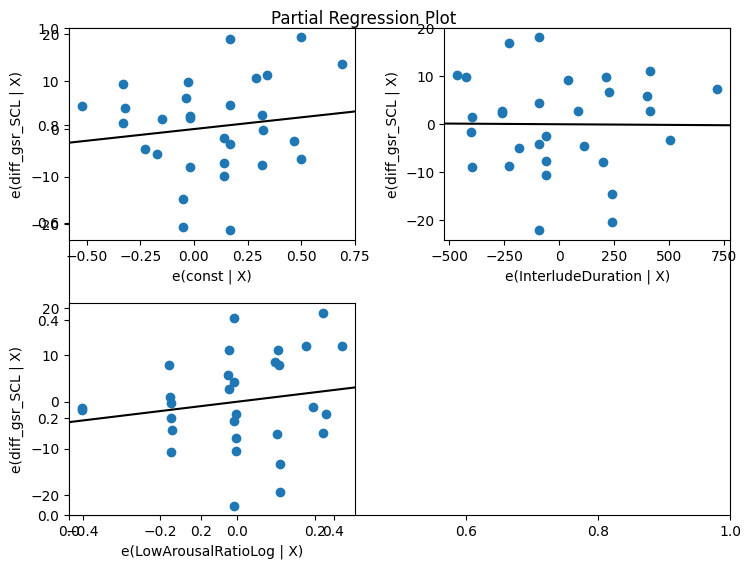

In [ ]:
# 7. Linearity of Relationships: Partial Regression Plots
fig, ax = plt.subplots(figsize=(8, 6))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

##### Fit models

###### change model here (optional)

In [ ]:
# model_name = "model" # put model here... ('model1', 'model2', 'model3', 'model4')
# ------
model_info = models[model_name]
model = model_info['model_no_interaction']
# print(model.summary())
response_var = model_info['response_var']
print(f"Selected model: {model_name}\n-Predictors: {', '.join(X.columns.tolist())}\n-Response Variable: {response_var}")

Selected model: model4
-Predictors: const, InterludeDuration, LowArousalRatioLog
-Response Variable: diff_gsr_SCL


###### View model summaries

In [ ]:
# Print selected model results with and without the interaction term
formula_no_interaction = derive_formula(models[model_name]['model_no_interaction'])
formula_w_interaction = derive_formula(models[model_name]['model_w_interaction'])

print(f"Summary for {formula_no_interaction}:")
model = models[model_name]['model_no_interaction']
print(model.summary())

Summary for diff_gsr_SCL ~ const + InterludeDuration + LowArousalRatioLog:
                            OLS Regression Results                            
Dep. Variable:           diff_gsr_SCL   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.4719
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.629
Time:                        14:47:54   Log-Likelihood:                -111.01
No. Observations:                  30   AIC:                             228.0
Df Residuals:                      27   BIC:                             232.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [ ]:
# Extract Beta Coefficients
beta_coefficients = model.params
print("Beta Coefficients:\n", beta_coefficients)

# Extract Confidence Intervals
confidence_intervals = model.conf_int()
confidence_intervals.columns = ['Lower CI', 'Upper CI']
print("Confidence Intervals:\n", confidence_intervals)

Beta Coefficients:
 const                  4.920197
InterludeDuration     -0.000271
LowArousalRatioLog    10.004482
dtype: float64
Confidence Intervals:
                      Lower CI   Upper CI
const               -8.279777  18.120171
InterludeDuration   -0.013065   0.012522
LowArousalRatioLog -12.773437  32.782400


In [ ]:
print(f"\nSummary for {formula_w_interaction}:")
model = models[model_name]['model_w_interaction']
print(model.summary())


Summary for diff_gsr_SCL ~ const + InterludeDuration + LowArousalRatioLog + Interaction:
                            OLS Regression Results                            
Dep. Variable:           diff_gsr_SCL   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.267
Date:                Sun, 02 Jun 2024   Prob (F-statistic):              0.306
Time:                        14:47:54   Log-Likelihood:                -109.48
No. Observations:                  30   AIC:                             227.0
Df Residuals:                      26   BIC:                             232.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [ ]:
# Extract Beta Coefficients
beta_coefficients = model.params
print("Beta Coefficients:\n", beta_coefficients)

# Extract Confidence Intervals
confidence_intervals = model.conf_int()
confidence_intervals.columns = ['Lower CI', 'Upper CI']
print("Confidence Intervals:\n", confidence_intervals)


Beta Coefficients:
 const                 19.669640
InterludeDuration     -0.018498
LowArousalRatioLog    67.328060
Interaction           -0.064786
dtype: float64
Confidence Intervals:
                     Lower CI    Upper CI
const              -2.531475   41.870755
InterludeDuration  -0.044117    0.007121
LowArousalRatioLog -6.540216  141.196335
Interaction        -0.144448    0.014876


### Multivariate Multiple Regression

#### Assumptions Checking

In [ ]:
y_1, y_2 = 'diff_ecg_Mean RR Interval', 'diff_gsr_Peak Amplitude'
y_1, y_2 = 'diff_gsr_SCL', 'diff_gsr_Peak Amplitude'
# y_1, y_2 = 'diff_ecg_Mean RR Interval', 'diff_gsr_SCL'
# y_1, y_2 = 'diff_ecg_Mean RR Interval', 'diff_ecg_Heart Rate'
#y_1, y_2 = 'diff_gsr_Peak Amplitude', 'diff_ecg_Heart Rate'
dependent_vars = [y_1, y_2]

In [ ]:
# Filter the relevant columns
relevant_columns = ['InterludeDuration', 'LowArousalRatioLog', y_1, y_2]
mvar_data = data[relevant_columns]

# Define the formula 
formula = f'Q("{y_1}") + Q("{y_2}") ~ Q("InterludeDuration") + Q("LowArousalRatioLog")'

# Fit the multivariate model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()

##### Assumptions checking

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


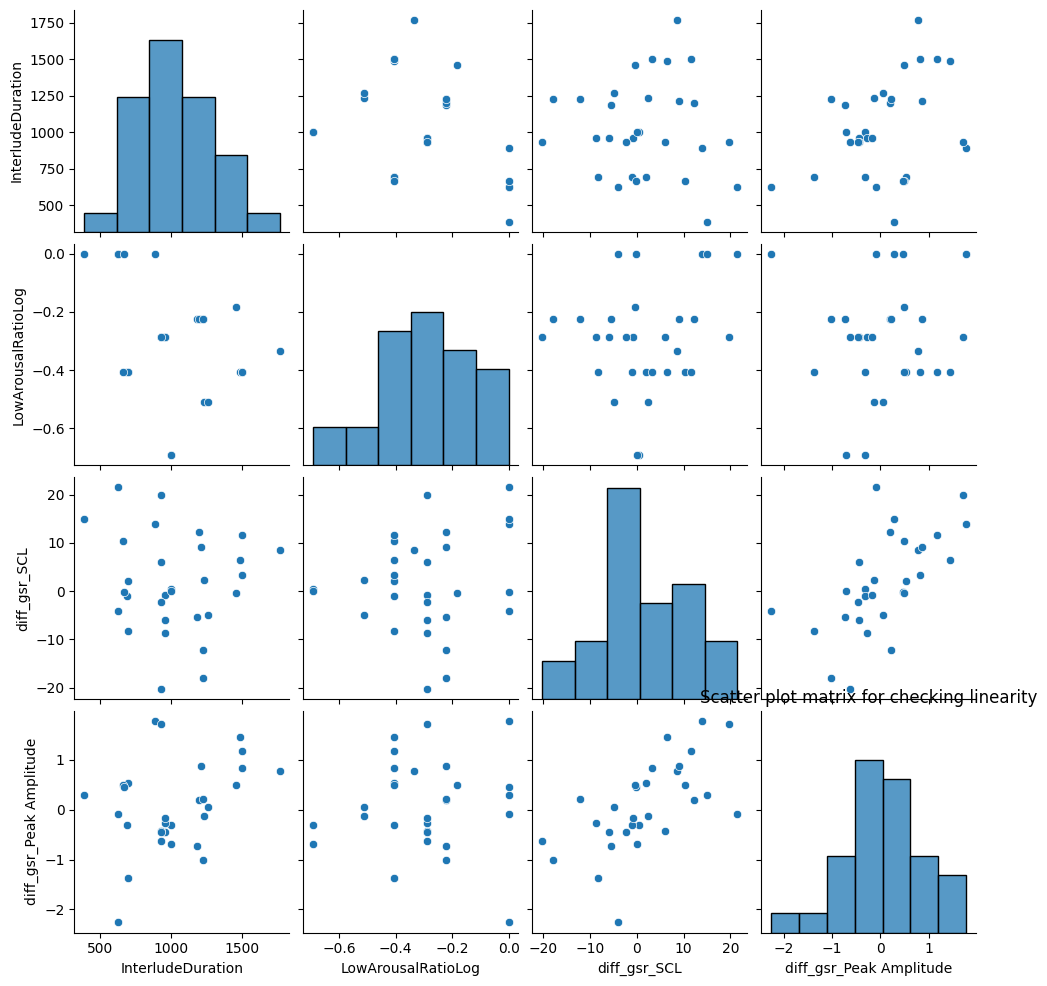

In [ ]:
# 1. Linearity: Scatter plot matrix
sns.pairplot(mvar_data)
plt.title('Scatter plot matrix for checking linearity')
plt.show()

In [ ]:
# 2. Multicollinearity: Variance Inflation Factor (VIF) 
X_no_interaction = mvar_data[['InterludeDuration', 'LowArousalRatioLog']]
vif_no_interaction = pd.DataFrame()
vif_no_interaction['Variable'] = X_no_interaction.columns
vif_no_interaction['VIF'] = [variance_inflation_factor(X_no_interaction.values, i) for i in range(X_no_interaction.shape[1])]
print(f'Variance Inflation Factor (without interaction):\n{vif_no_interaction}')


Variance Inflation Factor (without interaction):
             Variable       VIF
0   InterludeDuration  4.036631
1  LowArousalRatioLog  4.036631


In [ ]:
# 3. Multivariate Normality: Shapiro-Wilk test for each dependent variable

for var in dependent_vars:
    shapiro_test = shapiro(mvar_data[var])
    print(f'Shapiro-Wilk test for {var}: {shapiro_test}')


Shapiro-Wilk test for diff_gsr_SCL: ShapiroResult(statistic=0.9859188199043274, pvalue=0.9517725706100464)
Shapiro-Wilk test for diff_gsr_Peak Amplitude: ShapiroResult(statistic=0.9790917634963989, pvalue=0.8009209632873535)


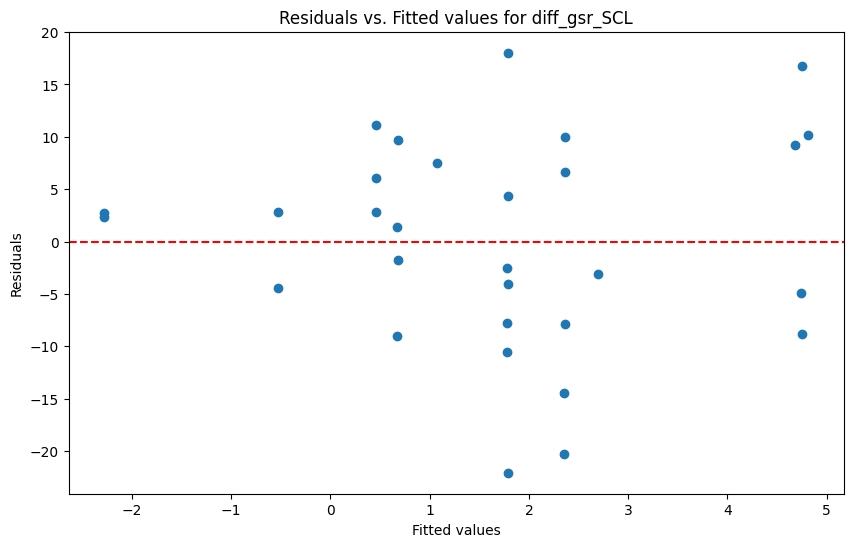

Breusch-Pagan test for diff_gsr_SCL: {'LM Statistic': 2.449078500982045, 'LM-Test p-value': 0.2938930802254319, 'F-Statistic': 1.2000527737134343, 'F-Test p-value': 0.3167384646877249}


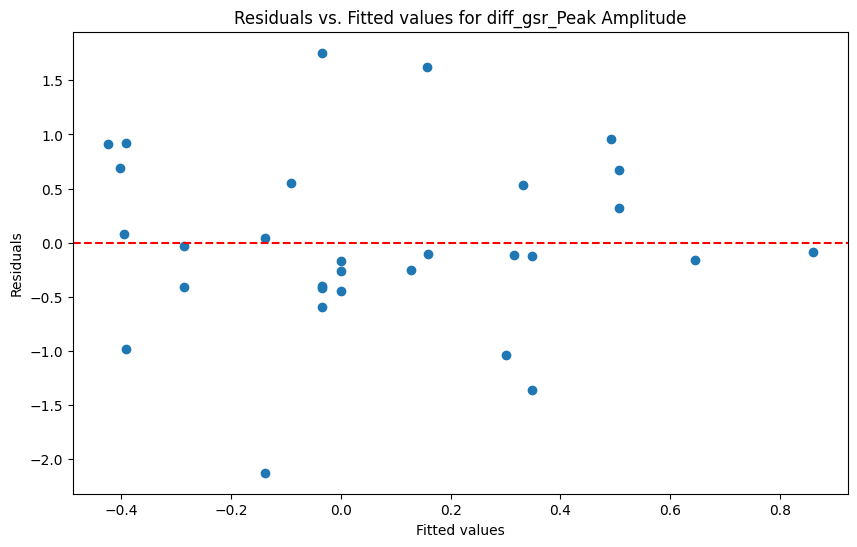

Breusch-Pagan test for diff_gsr_Peak Amplitude: {'LM Statistic': 4.77807949884502, 'LM-Test p-value': 0.09171771359289177, 'F-Statistic': 2.557460809990816, 'F-Test p-value': 0.09613203140064734}


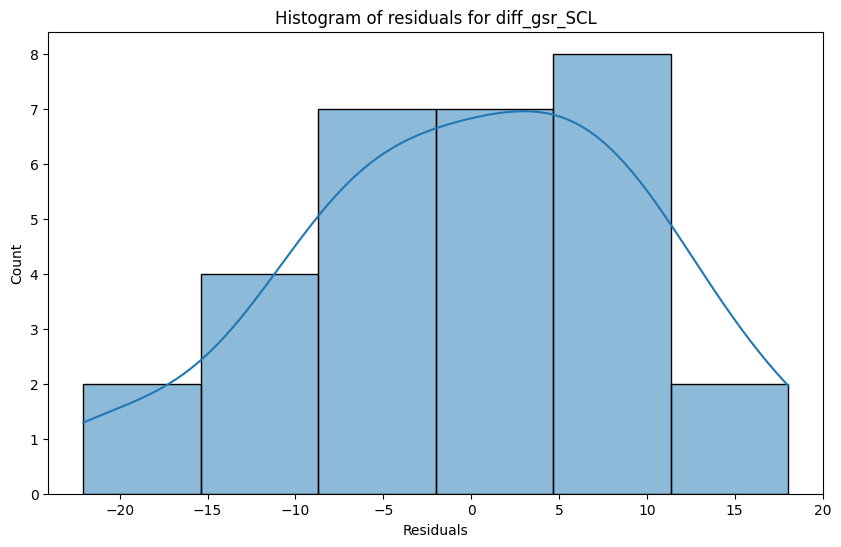

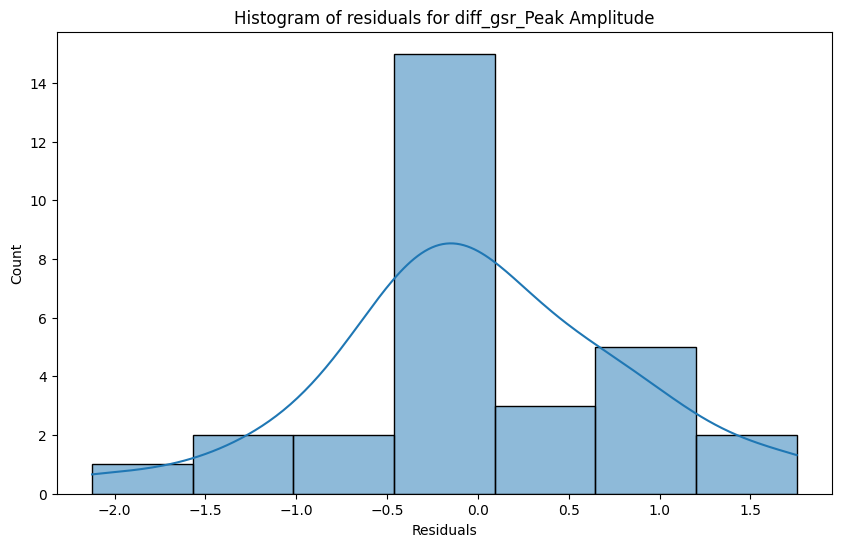

In [ ]:
# 4. Homoscedasticity: Plot residuals vs. fitted values and Breusch-Pagan test

# Fit OLS models for each dependent variable to get residuals
X = mvar_data[['InterludeDuration', 'LowArousalRatioLog']]
X = sm.add_constant(X)  

residuals = {}
for var in dependent_vars:
    model = sm.OLS(mvar_data[var], X).fit()
    residuals[var] = model.resid

    # Plot residuals vs. fitted values
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, model.resid)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted values for {var}')
    plt.show()

    # Breusch-Pagan test for homoscedasticity
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print(f'Breusch-Pagan test for {var}: {dict(zip(labels, bp_test))}')

# Additional check: Plot residuals for normality
for var, resid in residuals.items():
    plt.figure(figsize=(10, 6))
    sns.histplot(resid, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'Histogram of residuals for {var}')
    plt.show()

#### Fit Model 

In [ ]:
# Filter the relevant columns
relevant_columns = ['InterludeDuration', 'LowArousalRatioLog', y_1, y_2]
mvar_data = data[relevant_columns]

mvar_data_w_interaction = mvar_data.copy()

# Add the interaction term to the data
mvar_data_w_interaction['Interaction'] = mvar_data['InterludeDuration'] * mvar_data['LowArousalRatioLog']


###### Without interaction term

In [ ]:
# Define the formula without the interaction term
formula_no_interaction = f'Q("{y_1}") + Q("{y_2}") ~ Q("InterludeDuration") + Q("LowArousalRatioLog")'

# Fit the Multivariate Multiple Regression (MMR) model without the interaction term
mvar_model_no_interaction = MANOVA.from_formula(formula_no_interaction, data=mvar_data)
mvar_results_no_interaction = mvar_model_no_interaction.mv_test()

# Display the results
print(mvar_results_no_interaction)

                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.7571 2.0000 26.0000  4.1712 0.0268
          Pillai's trace 0.2429 2.0000 26.0000  4.1712 0.0268
  Hotelling-Lawley trace 0.3209 2.0000 26.0000  4.1712 0.0268
     Roy's greatest root 0.3209 2.0000 26.0000  4.1712 0.0268
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
  Q("InterludeDuration") Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.7525 2.0000 26.0000  4.2755 0.0248
          Pillai's trace 0.2475 2.0000 26.0000  4.2755 0.0248
  Hotelling-Lawley trace 0

In [ ]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.formula.api import ols


mvar_data_no_interaction = mvar_data

# Initialize dictionaries to store results
coefficients = {}
conf_intervals = {}

# Fit separate OLS models for each dependent variable
for y_var in dependent_vars:
    formula = f'Q("{y_var}") ~ Q("InterludeDuration") + Q("LowArousalRatioLog")'
    model = ols(formula, data=mvar_data_no_interaction).fit()
    
    # Extract coefficients
    coefficients[y_var] = model.params
    
    # Extract confidence intervals
    conf_intervals[y_var] = model.conf_int()
    conf_intervals[y_var].columns = ['Lower CI', 'Upper CI']

# Convert dictionaries to DataFrames for easier visualization
coefficients_df = pd.DataFrame(coefficients)
conf_intervals_df = pd.concat(conf_intervals, axis=1)

print("Coefficients:\n", coefficients_df)
print("\nConfidence Intervals:\n", conf_intervals_df)

Coefficients:
                          diff_gsr_SCL  diff_gsr_Peak Amplitude
Intercept                    4.920197                -0.831575
Q("InterludeDuration")      -0.000271                 0.001110
Q("LowArousalRatioLog")     10.004482                 0.813409

Confidence Intervals:
                         diff_gsr_SCL            diff_gsr_Peak Amplitude  \
                            Lower CI   Upper CI                Lower CI   
Intercept                  -8.279777  18.120171               -1.922018   
Q("InterludeDuration")     -0.013065   0.012522                0.000054   
Q("LowArousalRatioLog")   -12.773437  32.782400               -1.068262   

                                   
                         Upper CI  
Intercept                0.258868  
Q("InterludeDuration")   0.002167  
Q("LowArousalRatioLog")  2.695081  


###### With interaction term

In [ ]:
# Define the formula with interaction
formula_w_interaction = f'Q("{y_1}") + Q("{y_2}") ~ Q("InterludeDuration") + Q("LowArousalRatioLog") + Interaction'

# Fit the Mutlivariate Multiple Regression (MMR) model
mvar_model_w_interaction = MANOVA.from_formula(formula_w_interaction, data=mvar_data_w_interaction)
mvar_results_w_interaction = mvar_model_w_interaction.mv_test()

# Display the results
print(mvar_results_w_interaction)

                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.7303 2.0000 25.0000  4.6172 0.0197
          Pillai's trace 0.2697 2.0000 25.0000  4.6172 0.0197
  Hotelling-Lawley trace 0.3694 2.0000 25.0000  4.6172 0.0197
     Roy's greatest root 0.3694 2.0000 25.0000  4.6172 0.0197
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
  Q("InterludeDuration") Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.7714 2.0000 25.0000  3.7038 0.0390
          Pillai's trace 0.2286 2.0000 25.0000  3.7038 0.0390
  Hotelling-Lawley trace 0

In [ ]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.formula.api import ols


# Initialize dictionaries to store results
coefficients = {}
conf_intervals = {}

# Fit separate OLS models for each dependent variable
for y_var in dependent_vars:
    formula = f'Q("{y_var}") ~ Q("InterludeDuration") + Q("LowArousalRatioLog") + Interaction'
    model = ols(formula, data=mvar_data_w_interaction).fit()
    
    # Extract coefficients
    coefficients[y_var] = model.params
    
    # Extract confidence intervals
    conf_intervals[y_var] = model.conf_int()
    conf_intervals[y_var].columns = ['Lower CI', 'Upper CI']

# Convert dictionaries to DataFrames for easier visualization
coefficients_df = pd.DataFrame(coefficients)
conf_intervals_df = pd.concat(conf_intervals, axis=1)

print("Coefficients:\n", coefficients_df)
print("\nConfidence Intervals:\n", conf_intervals_df)

Coefficients:
                          diff_gsr_SCL  diff_gsr_Peak Amplitude
Intercept                   19.669640                -0.517571
Q("InterludeDuration")      -0.018498                 0.000722
Q("LowArousalRatioLog")     67.328060                 2.033784
Interaction                 -0.064786                -0.001379

Confidence Intervals:
                         diff_gsr_SCL             diff_gsr_Peak Amplitude  \
                            Lower CI    Upper CI                Lower CI   
Intercept                  -2.531475   41.870755               -2.441410   
Q("InterludeDuration")     -0.044117    0.007121               -0.001498   
Q("LowArousalRatioLog")    -6.540216  141.196335               -4.367276   
Interaction                -0.144448    0.014876               -0.008282   

                                   
                         Upper CI  
Intercept                1.406268  
Q("InterludeDuration")   0.002942  
Q("LowArousalRatioLog")  8.434843  
Interacti

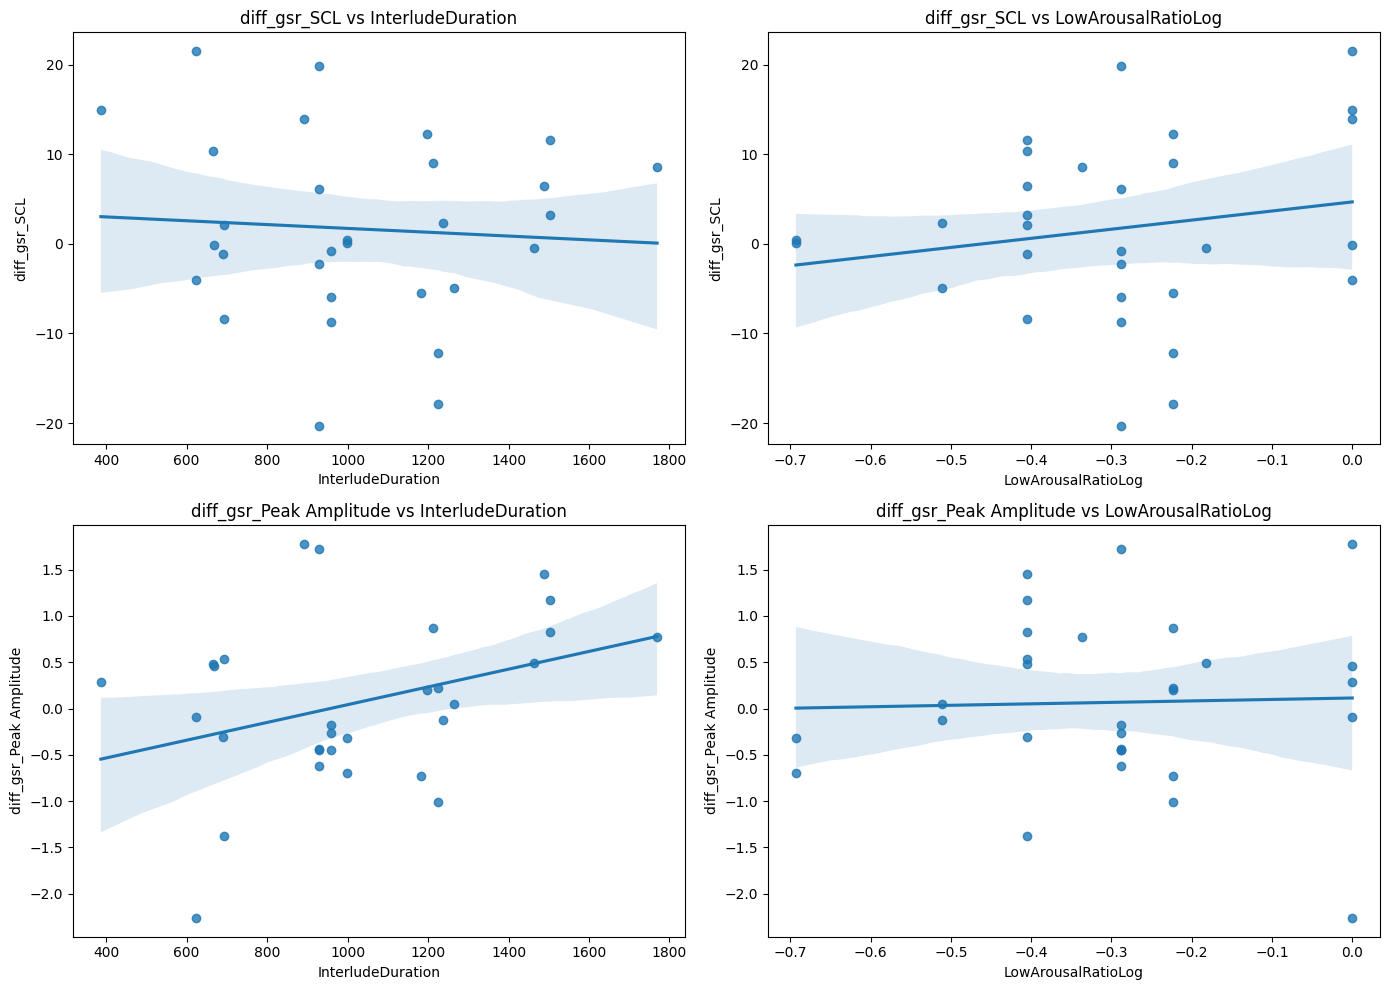

In [ ]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot diff_ecg_Heart Rate vs InterludeDuration
sns.regplot(x='InterludeDuration', y=y_1, data=mvar_data, ax=axes[0, 0])
axes[0, 0].set_title(f'{y_1} vs InterludeDuration')

sns.regplot(x='LowArousalRatioLog', y=y_1, data=mvar_data, ax=axes[0, 1])
axes[0, 1].set_title(f'{y_1} vs LowArousalRatioLog')

sns.regplot(x='InterludeDuration', y=y_2, data=mvar_data, ax=axes[1, 0])
axes[1, 0].set_title(f'{y_2} vs InterludeDuration')

sns.regplot(x='LowArousalRatioLog', y=y_2, data=mvar_data, ax=axes[1, 1])
axes[1, 1].set_title(f'{y_2} vs LowArousalRatioLog')

plt.tight_layout()
plt.show()

## G*Power 